<a href="https://colab.research.google.com/github/tushig0826/OOD/blob/main/DINOv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.6 MB/s eta 0:00:00


In [6]:
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoImageProcessor, AutoModel
import faiss
import os
import numpy as np


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [8]:
#Load CLIP model and processor
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
#Load DINOv2 model and processor
processor_dino = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model_dino = AutoModel.from_pretrained('facebook/dinov2-base').to(device)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
import requests
from PIL import Image
from io import BytesIO
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path
folder_path = '/content/drive/My Drive/OOD_examples'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define the test images dictionary
test_images = {
    '1': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/Gaussian_5_2.png',
    '2': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/Gaussian_5_3.png',
    '3': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/Gaussian_5_4.png',
    '4': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/Gaussian_5_5.png',
    '5': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_brown_cat.png',
    '6': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_brown_cow.png',
    '7': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_brown_dog.png',
    '8': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_brown_horse.png',
    '9': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_green_cat.png',
    '10': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_green_unknown.png',
    '11': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_pink_cow.png',
    '12': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_pink_unknown.png',
    '13': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_purple_dog.png',
    '14': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_purple_horse.png',
    '15': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_red_duck.png',
    '16': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_red_unknown.png',
    '17': 'https://raw.githubusercontent.com/modafarshouha/ReDiT/main/data/3U-VQA%20dataset/images/white_house_yellow_unknown.png',
}

# Download and save images
for name, url in test_images.items():
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        img.save(os.path.join(folder_path, f'{name}.png'))
        print(f"Image {name}.png downloaded successfully.")
    else:
        print(f"Failed to download image {name}.png.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image 1.png downloaded successfully.
Image 2.png downloaded successfully.
Image 3.png downloaded successfully.
Image 4.png downloaded successfully.
Image 5.png downloaded successfully.
Image 6.png downloaded successfully.
Image 7.png downloaded successfully.
Image 8.png downloaded successfully.
Image 9.png downloaded successfully.
Image 10.png downloaded successfully.
Image 11.png downloaded successfully.
Image 12.png downloaded successfully.
Image 13.png downloaded successfully.
Image 14.png downloaded successfully.
Image 15.png downloaded successfully.
Image 16.png downloaded successfully.
Image 17.png downloaded successfully.


In [15]:
#Retrieve all filenames
images = []
for root, dirs, files in os.walk('/content/drive/My Drive/OOD_examples'):
    for file in files:
        if file.endswith('png'):
            images.append(root  + '/'+ file)

In [16]:
images

['/content/drive/My Drive/OOD_examples/1.png',
 '/content/drive/My Drive/OOD_examples/2.png',
 '/content/drive/My Drive/OOD_examples/3.png',
 '/content/drive/My Drive/OOD_examples/4.png',
 '/content/drive/My Drive/OOD_examples/5.png',
 '/content/drive/My Drive/OOD_examples/6.png',
 '/content/drive/My Drive/OOD_examples/7.png',
 '/content/drive/My Drive/OOD_examples/8.png',
 '/content/drive/My Drive/OOD_examples/9.png',
 '/content/drive/My Drive/OOD_examples/10.png',
 '/content/drive/My Drive/OOD_examples/11.png',
 '/content/drive/My Drive/OOD_examples/12.png',
 '/content/drive/My Drive/OOD_examples/13.png',
 '/content/drive/My Drive/OOD_examples/14.png',
 '/content/drive/My Drive/OOD_examples/15.png',
 '/content/drive/My Drive/OOD_examples/16.png',
 '/content/drive/My Drive/OOD_examples/17.png']

In [17]:
#Define a function that normalizes embeddings and add them to the index
def add_vector_to_index(embedding, index):
    #convert embedding to numpy
    vector = embedding.detach().cpu().numpy()
    #Convert to float32 numpy
    vector = np.float32(vector)
    #Normalize vector: important to avoid wrong results when searching
    faiss.normalize_L2(vector)
    #Add to index
    index.add(vector)

In [18]:
def extract_features_clip(image):
    with torch.no_grad():
        inputs = processor_clip(images=image, return_tensors="pt").to(device)
        image_features = model_clip.get_image_features(**inputs)
        return image_features

In [19]:
def extract_features_dino(image):
    with torch.no_grad():
        inputs = processor_dino(images=image, return_tensors="pt").to(device)
        outputs = model_dino(**inputs)
        image_features = outputs.last_hidden_state
        return image_features.mean(dim=1)

In [20]:
# clip index
index_clip = faiss.IndexFlatL2(512)

In [21]:
index_clip

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f4f9c297cc0> >

In [22]:
# dino index
index_dino = faiss.IndexFlatL2(768)

In [23]:
index_dino

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f4f9c2663d0> >

In [24]:
#Iterate over the dataset to extract features X2 and store features in indexes
for image_path in images:
    img = Image.open(image_path).convert('RGB')
    clip_features = extract_features_clip(img)
    add_vector_to_index(clip_features,index_clip)
    dino_features = extract_features_dino(img)
    add_vector_to_index(dino_features,index_dino)

In [25]:
#store the indexes locally
faiss.write_index(index_clip,"clip.index")
faiss.write_index(index_dino,"dino.index")

In [26]:
print(faiss.write_index(index_clip,"clip.index"))

None


# **Similarity search**

In [33]:
image = Image.open('/content/drive/MyDrive/OOD_examples/7.png')

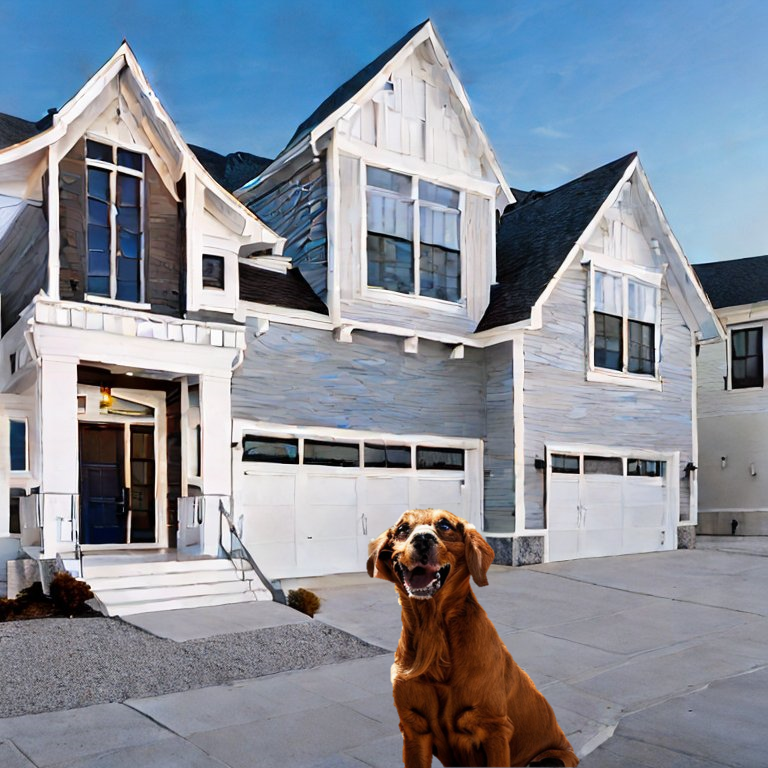

In [34]:
image

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


In [38]:
def normalizeL2(embeddings):
    vector = embeddings.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    return vector

In [36]:
# CLIP
processor_clip = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [37]:
#Extract features for CLIP
with torch.no_grad():
    inputs_clip = processor_clip(images=image, return_tensors="pt").to(device)
    image_features_clip = model_clip.get_image_features(**inputs_clip)

In [39]:
image_features_clip = normalizeL2(image_features_clip)

In [41]:
index_clip = faiss.read_index("clip.index")

In [42]:
index_clip

<faiss.swigfaiss.IndexFlat; proxy of <Swig Object of type 'faiss::IndexFlat *' at 0x7f4f9c0f54a0> >

In [43]:
d_clip,i_clip = index_clip.search(image_features_clip,5)

In [45]:
i_clip

array([[ 6, 12,  4, 14,  7]])

In [46]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base').to(device)


In [48]:
image1 = Image.open('/content/drive/MyDrive/OOD_examples/7.png')
with torch.no_grad():
    inputs1 = processor(images=image1, return_tensors="pt").to(device)
    outputs1 = model(**inputs1)
    image_features1 = outputs1.last_hidden_state
    image_features1 = image_features1.mean(dim=1)

In [49]:
image2 = Image.open('/content/drive/MyDrive/OOD_examples/8.png')
with torch.no_grad():
    inputs2 = processor(images=image2, return_tensors="pt").to(device)
    outputs2 = model(**inputs2)
    image_features2 = outputs2.last_hidden_state
    image_features2 = image_features2.mean(dim=1)


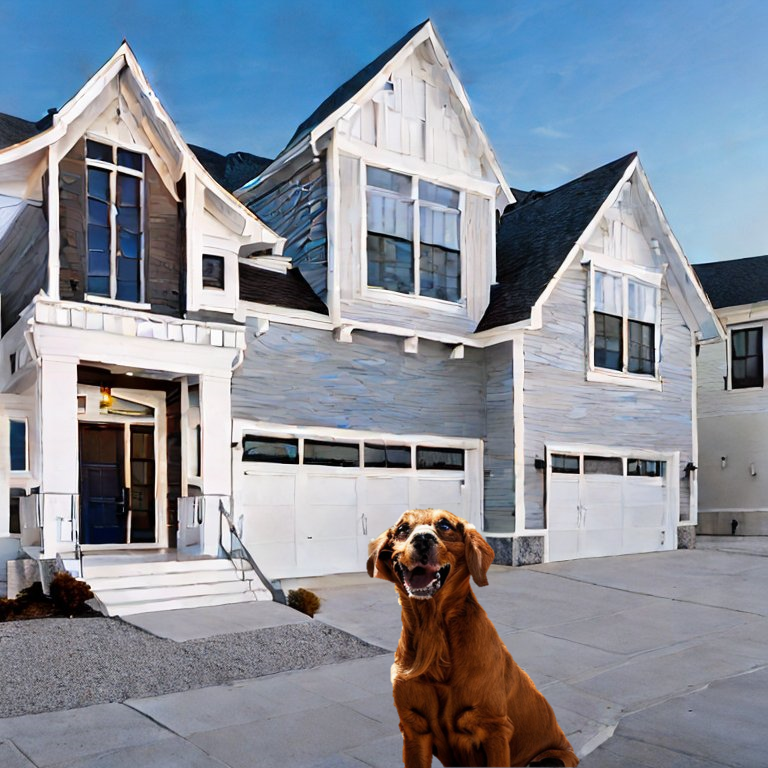

In [51]:
image1

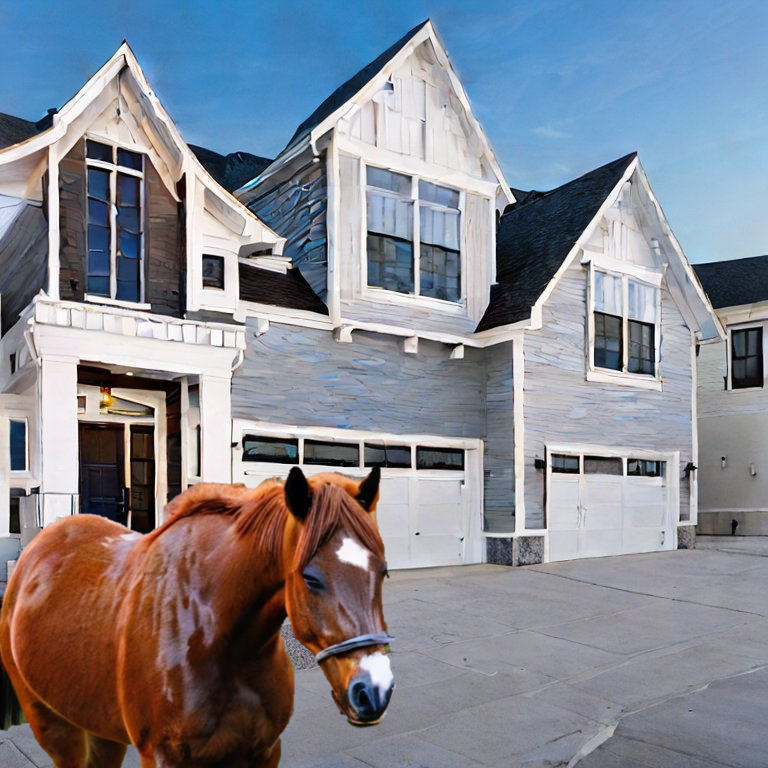

In [52]:
image2

In [50]:
cos = nn.CosineSimilarity(dim=0)
sim = cos(image_features1[0],image_features2[0]).item()
sim = (sim+1)/2
print('Similarity:', sim)

Similarity: 0.9434013962745667


In [54]:
cos = nn.CosineSimilarity(dim=2)
sims = cos(image_features1.unsqueeze(2), image_features2.unsqueeze(1))

# Normalize similarity values to range [0, 1]
sims = (sims + 1) / 2

# Convert similarity matrix to a list of lists for token by token probabilities
token_by_token_probs = sims.tolist()

print('Token by token similarities:', token_by_token_probs)

Token by token similarities: [[0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.7413429617881775, 0.7413429617881775, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.2586570382118225, 0.2586570382118225, 0.7413429617881775, 0.2586570382118225, 0.7413429617881775, 0.7413429617881775, 0.2586570

In [55]:
import pprint
pprint.pprint(token_by_token_probs)

[[0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.7413429617881775,
  0.7413429617881775,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.2586570382118225,
  0.2586570382118225,
  0.2586570382118225,
  0.7413429617881775,
  0.258657

# **CLIP image similarities**

In [56]:
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [57]:
image1 = Image.open('/content/drive/MyDrive/OOD_examples/7.png')
with torch.no_grad():
    inputs1 = processor(images=image1, return_tensors="pt").to(device)
    image_features1 = model.get_image_features(**inputs1)


In [58]:
image2 = Image.open('/content/drive/MyDrive/OOD_examples/8.png')
with torch.no_grad():
    inputs2 = processor(images=image2, return_tensors="pt").to(device)
    image_features2 = model.get_image_features(**inputs2)

In [59]:
image1, image2

(<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=768x768>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=768x768>)

In [60]:
cos = nn.CosineSimilarity(dim=0)
sim = cos(image_features1[0],image_features2[0]).item()
sim = (sim+1)/2
print('Similarity:', sim)

Similarity: 0.9445266127586365


In [61]:
cos = nn.CosineSimilarity(dim=2)
sims = cos(image_features1.unsqueeze(2), image_features2.unsqueeze(1))

# Normalize similarity values to range [0, 1]
sims = (sims + 1) / 2

# Convert similarity matrix to a list of lists for token by token probabilities
token_by_token_probs = sims.tolist()

print('Token by token similarities:', token_by_token_probs)

Token by token similarities: [[0.507705569267273, 0.507705569267273, 0.49229443073272705, 0.49229443073272705, 0.507705569267273, 0.49229443073272705, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.49229443073272705, 0.49229443073272705, 0.507705569267273, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.507705569267273, 0.507705569267273, 0.49229443073272705, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.507705569267273, 0.49229443073272705, 0.507705569267273, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705, 0.49229443073272705

In [62]:
pprint.pprint(token_by_token_probs)

[[0.507705569267273,
  0.507705569267273,
  0.49229443073272705,
  0.49229443073272705,
  0.507705569267273,
  0.49229443073272705,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.49229443073272705,
  0.49229443073272705,
  0.507705569267273,
  0.49229443073272705,
  0.49229443073272705,
  0.49229443073272705,
  0.507705569267273,
  0.507705569267273,
  0.49229443073272705,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.49229443073272705,
  0.49229443073272705,
  0.49229443073272705,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.507705569267273,
  0.49229443073272705,
  0.507705569267273,
  0.49229443073272705,
  0.49229443073272705,
  0.49229443073272705,
  0.49229443073272705,
